Importing and processing data for multi-view analysis using Random Forest and PLS regression.

In [ ]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, KernelPCA
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
from scipy.stats import spearmanr, sem
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

import numpy as np
import random

# Setting random seed for reproducibility
SEED = 42
np.random.seed(SEED)
random.seed(SEED)


# Loading data
# Metadata
metadata = (
    pd.read_csv("combined_metadata_day3_4.csv")
      .drop_duplicates("sample_id")
      .set_index("sample_id")
)
metadata = metadata[metadata["Group"].isin([0, 1])]
metadata["day"] = metadata["day"].astype(int)

# Omics
metab = pd.read_csv("Metabolomic_Matrix.csv", index_col=0)
trans = pd.read_csv("Transcriptomic_Matrix.csv", index_col=0)

# Alignning samples
shared = metadata.index.intersection(metab.index).intersection(trans.index)
metadata = metadata.loc[shared]
metab = metab.loc[shared]
trans = trans.loc[shared]

# Extracting labels and covariates
y = metadata["Group"].values
# setting day as a covariate
day = metadata["day"].values.reshape(-1, 1)


# Standard scaling of omics data
scaler = StandardScaler()
metab_s = pd.DataFrame(scaler.fit_transform(metab), index=metab.index, columns=metab.columns)
trans_s = pd.DataFrame(scaler.fit_transform(trans), index=trans.index, columns=trans.columns)



Dimensionality Reduction
Apply PCA and KernelPCA separately to metabolomics and transcriptomics datasets.



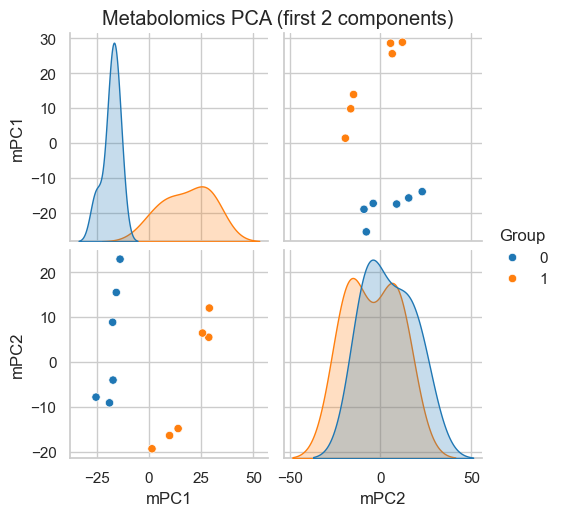

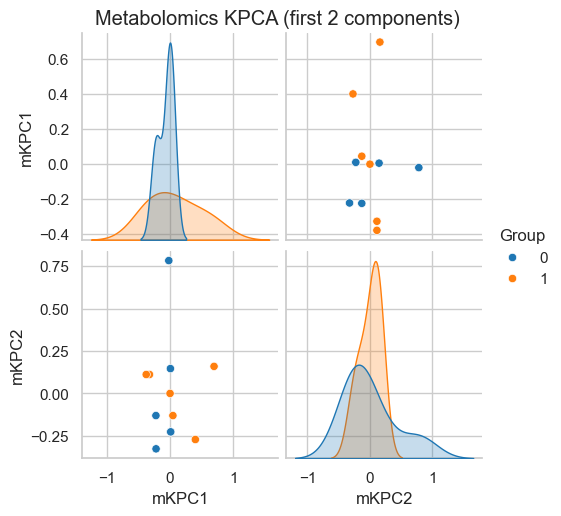

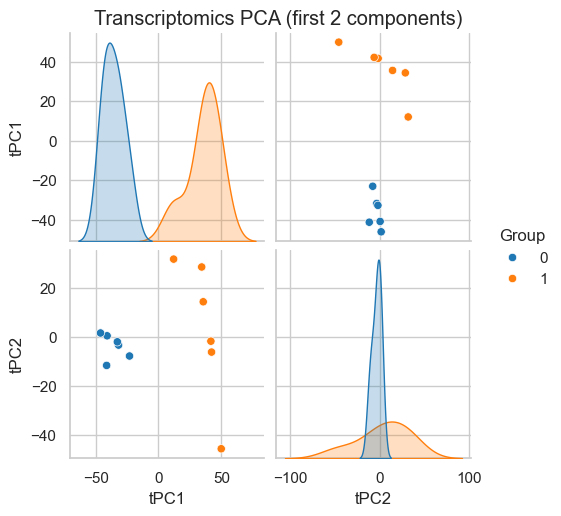

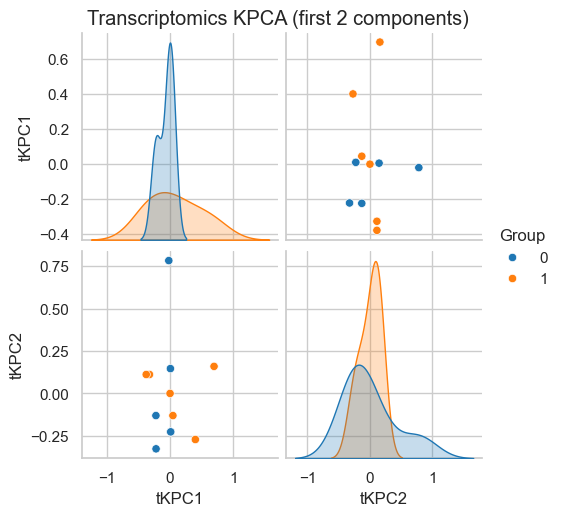

In [ ]:
# Dimensionality Reduction
# Number of components
n_comp = 2
# PCA
pca_met = PCA(n_components=n_comp, random_state=42).fit(metab_s)
pca_tr = PCA(n_components=n_comp, random_state=42).fit(trans_s)
met_pca = pd.DataFrame(pca_met.transform(metab_s), index=metab.index,
                       columns=[f"mPC{i+1}" for i in range(n_comp)])
tr_pca = pd.DataFrame(pca_tr.transform(trans_s), index=trans.index,
                      columns=[f"tPC{i+1}" for i in range(n_comp)])

# KPCA 
kpca_met = KernelPCA(n_components=n_comp, kernel='rbf', gamma=0.1, random_state=42)
kpca_tr = KernelPCA(n_components=n_comp, kernel='rbf', gamma=0.1, random_state=42)
met_kpca = pd.DataFrame(kpca_met.fit_transform(metab_s), index=metab.index,
                        columns=[f"mKPC{i+1}" for i in range(n_comp)])
tr_kpca = pd.DataFrame(kpca_tr.fit_transform(trans_s), index=trans.index,
                       columns=[f"tKPC{i+1}" for i in range(n_comp)])

# Plotting PCA vs KPCA for future inspection to determine best for modelling
for df, title in [(met_pca, "Metabolomics PCA"), (met_kpca, "Metabolomics KPCA"),
                  (tr_pca, "Transcriptomics PCA"), (tr_kpca, "Transcriptomics KPCA")]:
    df["Group"] = metadata["Group"]
    sns.pairplot(df, hue="Group", palette="tab10")
    plt.suptitle(f"{title} (first {n_comp} components)", y=1.02)
    plt.show()
    df.drop(columns="Group", inplace=True)




Training and evaluating models with cross-validation.

Uses 5-fold StratifiedKFold to evaluate:

Random Forest Classifier (RF)

Partial Least Squares Regression (PLS)

Evaluate models with Accuracy and ROC-AUC.

Collect feature importance (RF) and coefficients (PLS).

RF   — Accuracy: 1.000 ± 0.000, AUC: 1.000 ± 0.000
PLS  — Accuracy: 1.000 ± 0.000, AUC: 1.000 ± 0.000


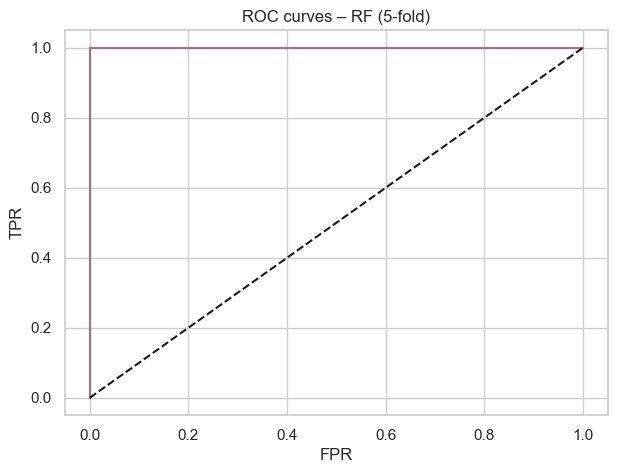

In [ ]:
# Train & Evaluate Models via CV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
acc_rf, auc_rf, acc_pls, auc_pls = [], [], [], []
rf_imps, pls_coefs = [], []

# Combined data for modelling
X_full = pd.concat([met_pca, tr_pca], axis=1)
X_full["day"] = metadata["day"].values

for tr_idx, te_idx in cv.split(X_full, y):
    X_tr, X_te = X_full.iloc[tr_idx], X_full.iloc[te_idx]
    y_tr, y_te = y[tr_idx], y[te_idx]

    # Random Forest Classifier (RF)
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X_tr, y_tr)
    pred_rf = rf.predict(X_te)
    prob_rf = rf.predict_proba(X_te)[:, 1]
    acc_rf.append(accuracy_score(y_te, pred_rf))
    auc_rf.append(roc_auc_score(y_te, prob_rf))
    rf_imps.append(pd.Series(rf.feature_importances_, index=X_full.columns))
    
    # PLS Regression 
    max_pls_comp = min(X_tr.shape[0] - 1, X_tr.shape[1])
    pls = PLSRegression(n_components=min(n_comp*2, max_pls_comp))
    pls.fit(X_tr, y_tr)
    pred_pls = pls.predict(X_te).ravel()
    acc_pls.append(accuracy_score(y_te, (pred_pls > 0.5).astype(int)))
    auc_pls.append(roc_auc_score(y_te, pred_pls))
    pls_coefs.append(pd.Series(pls.coef_.ravel(), index=X_full.columns))

# Reportting metrics
print(f"RF   — Accuracy: {np.mean(acc_rf):.3f} ± {np.std(acc_rf):.3f}, AUC: {np.mean(auc_rf):.3f} ± {np.std(auc_rf):.3f}")
print(f"PLS  — Accuracy: {np.mean(acc_pls):.3f} ± {np.std(acc_pls):.3f}, AUC: {np.mean(auc_pls):.3f} ± {np.std(auc_pls):.3f}")

# Plot mean ROC for RF
plt.figure(figsize=(7,5))
for fpr, tpr, _ in [roc_curve(y[te_idx], rf.predict_proba(X_full.iloc[te_idx])[:,1]) for tr_idx, te_idx in cv.split(X_full, y)]:
    plt.plot(fpr, tpr, alpha=0.4)
plt.plot([0,1], [0,1], 'k--')
plt.title("ROC curves – RF (5-fold)")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.show()



Featurre importance and coefficients

Plots average feature importances from RF and PLS.
Visualisess the top 10 most informative features from both model

C:\Users\samri\AppData\Local\Temp\ipykernel_13820\3717308636.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=rf_avg.head(10).index, x=rf_avg.head(10).values, ax=axes[0], palette="viridis")
C:\Users\samri\AppData\Local\Temp\ipykernel_13820\3717308636.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=pls_avg.head(10).index, x=pls_avg.head(10).values, ax=axes[1], palette="magma")


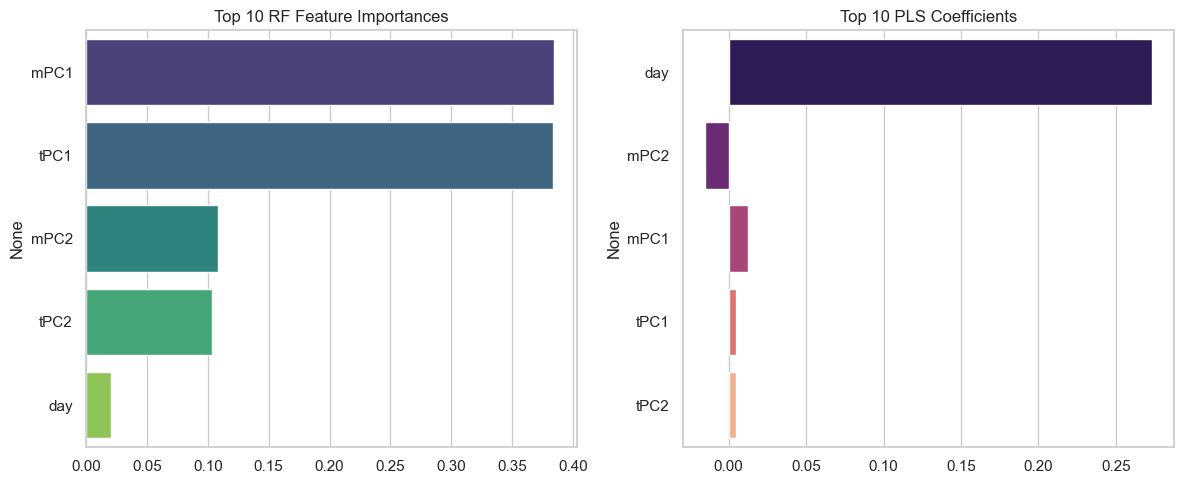

In [ ]:
# Feature Importance & PLS Coefficients Averaging
rf_avg = pd.concat(rf_imps, axis=1).mean(axis=1).sort_values(ascending=False)
pls_avg = pd.concat(pls_coefs, axis=1).mean(axis=1).sort_values(key=lambda s: s.abs(), ascending=False)

fig, axes = plt.subplots(1, 2, figsize=(12,5))
sns.barplot(y=rf_avg.head(10).index, x=rf_avg.head(10).values, ax=axes[0], palette="viridis")
axes[0].set_title("Top 10 RF Feature Importances")
sns.barplot(y=pls_avg.head(10).index, x=pls_avg.head(10).values, ax=axes[1], palette="magma")
axes[1].set_title("Top 10 PLS Coefficients")
plt.tight_layout()
plt.show()

Block score correlation and bootstrap importance
Calculates and plots Spearman correlations between PCA scores.

Uses bootstrapping with RF to assess relative importance of metabolomics vs transcriptomics blocks.

c:\Users\samri\Documents\101_bioinformatics\python\Visual_studio_code\.conda\Lib\site-packages\seaborn\matrix.py:1124: UserWarning: ``square=True`` ignored in clustermap
  warnings.warn(msg)


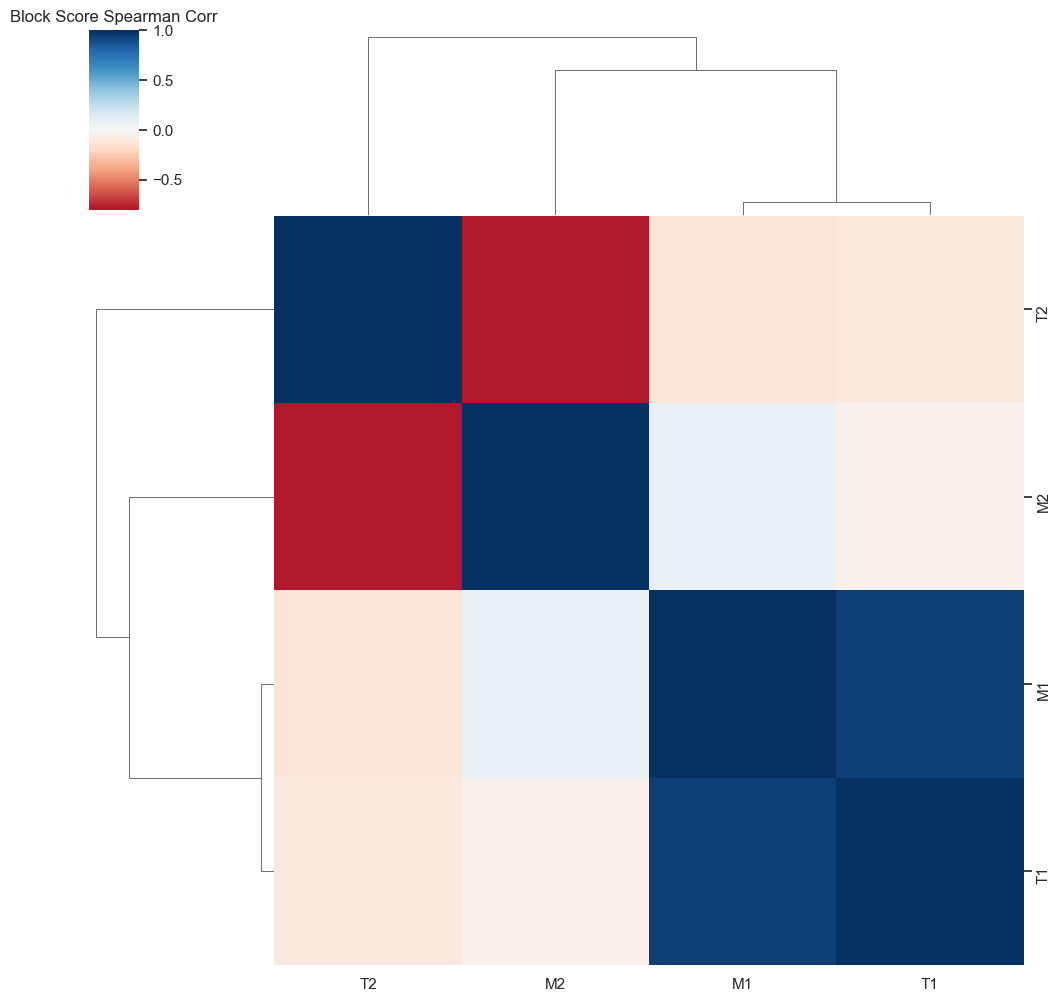

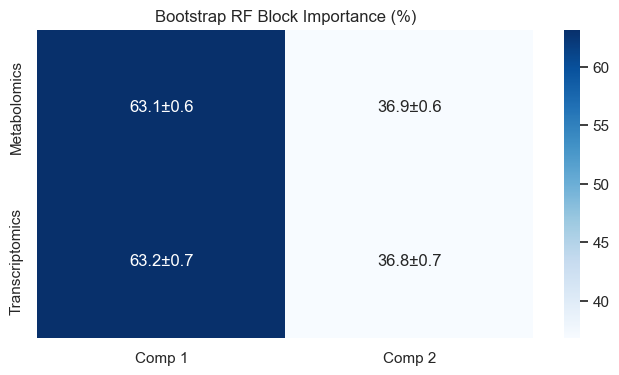

In [ ]:

# Block Score Correlation & Bootstrap Importance 
# Block scoress
m_mat = met_pca.values[:, :2]
t_mat = tr_pca.values[:, :2]

# Heatmap correlations between metabolites/transcriptomes block scores
block_df = pd.DataFrame(np.hstack([m_mat, t_mat]), 
                        columns=[f"M{i+1}" for i in range(2)] + [f"T{i+1}" for i in range(2)],
                        index=metadata.index)
sns.clustermap(block_df.corr(method="spearman"), cmap="RdBu", center=0, square=True)
plt.title("Block Score Spearman Corr")
plt.show()

# Bootstrap block importance via RF
# Using only first 2 components from each omics for simplicity
n_boot = 100
boot_imp = np.zeros((n_boot, 2, 2))
for i in range(n_boot):
    idxs = np.random.choice(len(y), len(y), replace=True)
    for bi, mat in enumerate([m_mat, t_mat]):
        rf = RandomForestClassifier(n_estimators=100, random_state=i)
        rf.fit(mat[idxs], y[idxs])
        boot_imp[i, bi, :] = rf.feature_importances_
# Mean and SEM of bootstrapped importance
mean_imp = boot_imp.mean(axis=0)*100
sem_imp = sem(boot_imp, axis=0)*100

# Heatmap of bootstrapped importance with mean±SEM annotations
fig, ax = plt.subplots(figsize=(8,4))
sns.heatmap(mean_imp, 
            annot=[[f"{mean_imp[i,j]:.1f}±{sem_imp[i,j]:.1f}" for j in range(2)] for i in range(2)], 
            fmt="",  # <--- This is the fix!
            cmap="Blues", 
            xticklabels=[f"Comp {i+1}" for i in range(2)], 
            yticklabels=["Metabolomics", "Transcriptomics"], 
            ax=ax)
plt.title("Bootstrap RF Block Importance (%)")
plt.show()



Defines compute_vip() function to compute Variable Importance in Projection (VIP) scores from a PLS model.

Plots top 10 VIP features.

C:\Users\samri\AppData\Local\Temp\ipykernel_13820\1718796650.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=vip_scores.sort_values(ascending=False).head(10).index,


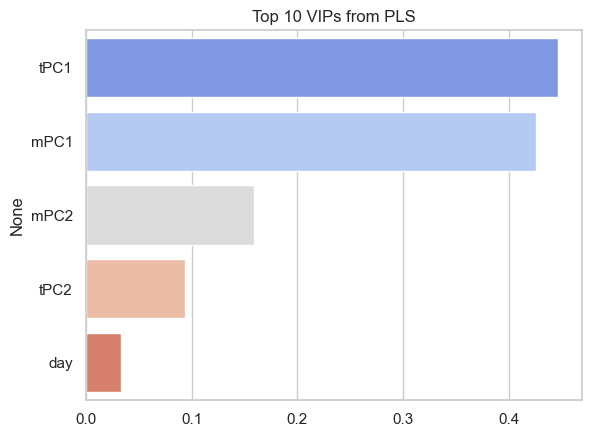

In [ ]:
# VIP from Full PLS Model 
def compute_vip(pls, X, y):
    T = pls.x_scores_
    W = pls.x_weights_
    Q = pls.y_loadings_.ravel()
    p, h = W.shape
    ss = np.sum((T * Q)**2, axis=0)
    Wnorm2 = (W**2).sum(axis=0)
    vip = np.sqrt((p * (W**2) @ ss) / (X.shape[0] * ss.sum()))
    return pd.Series(vip, index=X.columns)

# Fit PLS on full data and compute VIP scores
pls_full = PLSRegression(n_components=min(n_comp*2, X_full.shape[1]-1))
pls_full.fit(X_full, y)
vip_scores = compute_vip(pls_full, X_full, y)
# Plot top 10 VIP scores
sns.barplot(y=vip_scores.sort_values(ascending=False).head(10).index,
            x=vip_scores.sort_values(ascending=False).head(10).values,
            palette="coolwarm")
plt.title("Top 10 VIPs from PLS")
plt.show()


In [7]:
# print(vip_scores.head())
# print(vip_scores.describe())

# print("Features in VIP:", vip_df["FeatureID"].nunique())
# print("Features in Pathway DB:", pathway_long["FeatureID"].nunique())
# print("Merged VIP count:", vip_annotated.shape[0])

# print(vip_summary.head(10))
# print(vip_summary.describe())

# print(vip_summary.isna().sum())
# print((vip_summary["MeanVIP"] == 0).sum())


In [8]:
!pip install bioservices

Pathway-Level VIP Aggregation
Load wide-format pathway database.

Reshape pathway DB into long format.

Merge VIP scores with pathways and summarize:

Mean VIP per pathway

Number of features per pathway

Median adjusted p-value from external significance table

In [ ]:
# Integrate VIP with Pathway Database
# Loading VIP & Pathway DB 
pval_db = pd.read_csv("multiomics_pvalue_database.csv")  # feature-level p-values
pathway_db = pd.read_csv("Prokaryotic_Pathway_DB_with_BGCs.csv")  # wide format



In [ ]:

# Meltting the pathway database from wide to long 
pathway_long = pathway_db.melt(
    id_vars=["Pathway_id", "Pathway_name"],
    var_name="Variable",  # original column like V1, V2...
    value_name="FeatureID"
)

# Dropping the empty/None values
pathway_long = pathway_long.dropna(subset=["FeatureID"])

# Preparing the VIP scores from full model
X_omics = pd.concat([metab_s, trans_s], axis=1)
pls_full = PLSRegression(n_components=min(n_comp*2, X_omics.shape[1]-1))
pls_full.fit(X_omics, y)

# Function to compute Variable Importance in Projection (VIP) scores from a fitted PLS model
def compute_vip(pls, X, y):
    T = pls.x_scores_
    W = pls.x_weights_
    Q = pls.y_loadings_.ravel()
    p, h = W.shape
    ss = np.sum((T * Q)**2, axis=0)
    Wnorm2 = (W**2).sum(axis=0)
    vip = np.sqrt((p * (W**2) @ ss) / (X.shape[0] * ss.sum()))
    return pd.Series(vip, index=X.columns)

# Compute VIP scores
vip_scores = compute_vip(pls_full, X_omics, y)
vip_scores.name = "VIP"


C:\Users\samri\AppData\Local\Temp\ipykernel_13820\3452019905.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y="Pathway_name", x="MeanVIP", data=top_pathways, palette="crest")


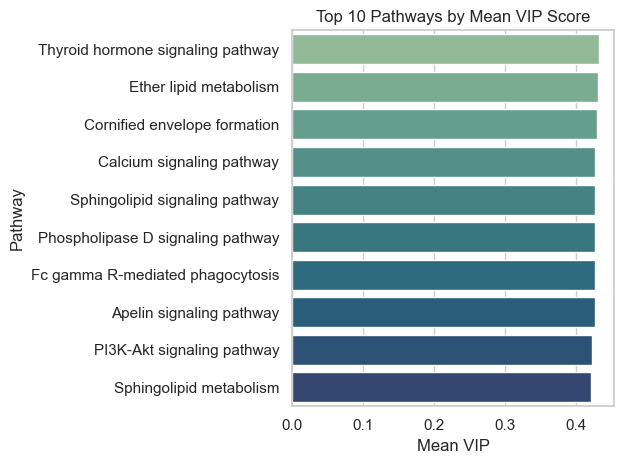

In [ ]:

# Annotating the VIPs with pathways
vip_df = vip_scores.reset_index().rename(columns={"index": "FeatureID"})
vip_annotated = vip_df.merge(pathway_long, on="FeatureID", how="inner")

# Aggregating the pathway-level summary
vip_summary = (
    vip_annotated
    .groupby(["Pathway_id", "Pathway_name"])
    .agg(
        MeanVIP=("VIP", "mean"),
        NumFeatures=("FeatureID", "count")
    )
    .reset_index()
)

# Adding the pathway p-values from feature-level DB
vip_annotated = vip_annotated.merge(pval_db, on="FeatureID", how="left")
pval_summary = (
    vip_annotated
    .groupby("Pathway_id")
    .agg(MedianPValue=("AdjPValue", "median"))
    .reset_index()
)

vip_summary = vip_summary.merge(pval_summary, on="Pathway_id", how="left")

# Visualising the top pathways
top_pathways = vip_summary.sort_values("MeanVIP", ascending=False).head(10)
sns.barplot(y="Pathway_name", x="MeanVIP", data=top_pathways, palette="crest")
plt.title("Top 10 Pathways by Mean VIP Score")
plt.xlabel("Mean VIP")
plt.ylabel("Pathway")
plt.tight_layout()
plt.show()


In [ ]:
# Check Omics Contributions to VIPs 
vip_annotated['Omics'] = vip_annotated['FeatureID'].apply(
    lambda f: 'Metabolite' if f in metab_s.columns else 'Transcript'
)
# Count unique VIP features by omics
om_view_counts = vip_annotated.groupby('Omics')['FeatureID'].nunique()
print("Unique VIP Features by Omics:\n", om_view_counts)



Unique VIP Features by Omics:
 Omics
Metabolite     247
Transcript    1729
Name: FeatureID, dtype: int64


In [13]:
!pip install adjustText


Visualising the Top Pathways by VIP vs Enrichment

4 [-0.95395479  0.30273442]
5 [ 0.54249334 -0.25112926]


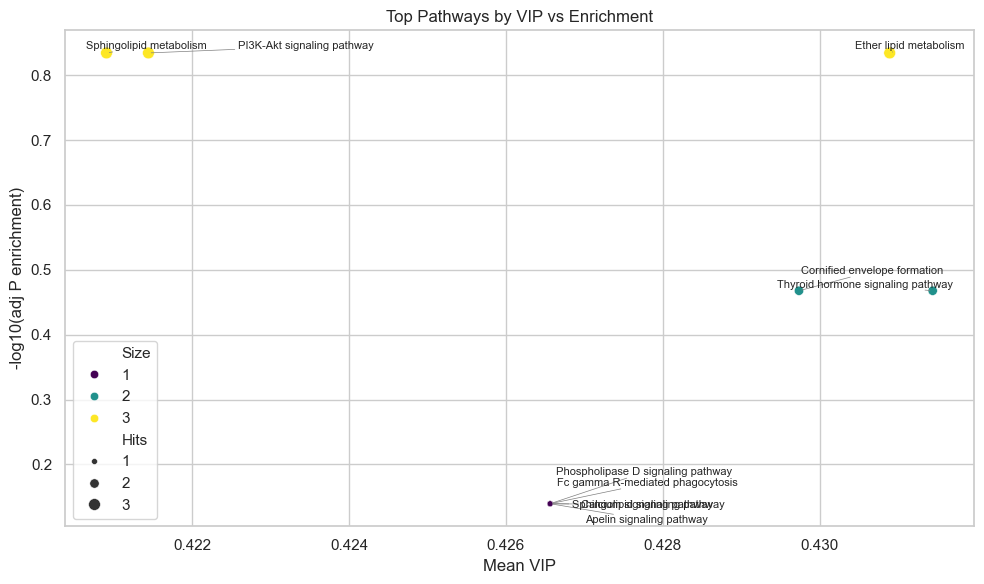

In [ ]:
# Visualise Top Pathways by VIP vs Enrichment
# Additional imports
import statsmodels.stats.multitest as smm  # Use this instead of sm
import adjustText
from scipy.stats import fisher_exact

# Identifying the   Enriched Pathways via Fisher’s Exact Testt
vip_thresh = vip_scores.quantile(0.75)  # Top quartile
high_vip = set(vip_scores[vip_scores > vip_thresh].index)

# Precomputing the background sets
all_feats = set(X_omics.columns)

# enrichment analysis
enrichment_results = []
for pid, group in pathway_long.groupby('Pathway_id'):
    feats = set(group['FeatureID'])
    a = len(high_vip & feats)
    b = len(feats) - a
    c = len(high_vip) - a
    d = len(all_feats) - (a + b + c)
    # Perform one-sided Fisher's exact test 
    _, p = fisher_exact([[a, b], [c, d]], alternative='greater')
    pathway_name = group['Pathway_name'].iloc[0]
    enrichment_results.append((pid, pathway_name, a, len(feats), p))

# Creating DataFrame and adjusting p-values
enrich_df = pd.DataFrame(enrichment_results, columns=['Pathway_id','Pathway_name','Hits','Size','P_enrich'])
enrich_df['AdjP'] = smm.multipletests(enrich_df['P_enrich'], method='fdr_bh')[1]
enrich_top = enrich_df[enrich_df['AdjP'] < 0.05].sort_values('AdjP')

# Merging VIP summary with enrichment results
viz_df = vip_summary.merge(enrich_df[['Pathway_id','Hits','Size','AdjP']], on='Pathway_id', how='left')
viz_top = viz_df.sort_values('MeanVIP', ascending=False).head(10)

from adjustText import adjust_text  # install via: pip install adjustText
# Scatter plot of Mean VIP vs -log10(adj P)
plt.figure(figsize=(10, 6))
plot = sns.scatterplot(data=viz_top, x='MeanVIP', y=-np.log10(viz_top['AdjP']),
                       size='Hits', hue='Size', palette='viridis', legend='brief')

# Addding labels with adjustText to avoid overlapping
texts = []
for _, row in viz_top.iterrows():
    texts.append(plt.text(row['MeanVIP'], -np.log10(row['AdjP']), row['Pathway_name'], fontsize=8))

adjust_text(texts, arrowprops=dict(arrowstyle='-', color='grey', lw=0.5))

plt.xlabel('Mean VIP')
plt.ylabel('-log10(adj P enrichment)')
plt.title('Top Pathways by VIP vs Enrichment')
plt.grid(True)
plt.tight_layout()
plt.show()


c:\Users\samri\Documents\101_bioinformatics\python\Visual_studio_code\.conda\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


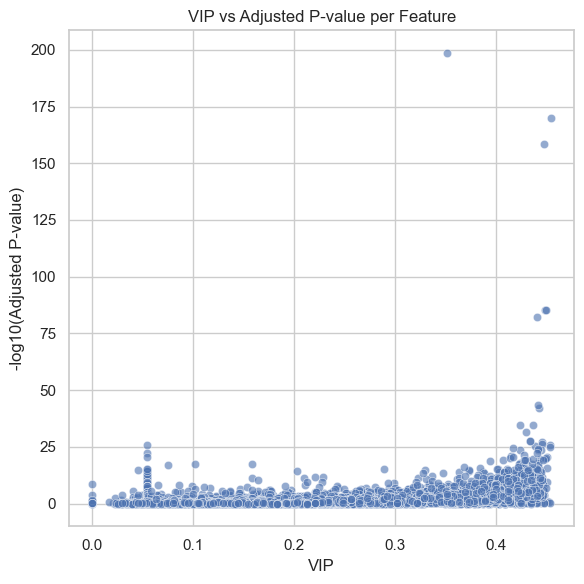

In [ ]:
# Scatter plotting VIP vs Adjusted P-values
# Merge VIPs and raw pvals
vip_pval = vip_scores.reset_index().rename(columns={"index": "FeatureID"}).merge(
    pval_db[["FeatureID", "AdjPValue"]], on="FeatureID", how="left"
)

# Scatter plot of VIP vs -log10(adj P)
plt.figure(figsize=(6,6))
sns.scatterplot(
    x=vip_pval["VIP"],
    y=-np.log10(vip_pval["AdjPValue"]),
    alpha=0.6
)
plt.xlabel("VIP")
plt.ylabel("-log10(Adjusted P-value)")
plt.title("VIP vs Adjusted P-value per Feature")
plt.grid(True)
plt.tight_layout()
plt.show()


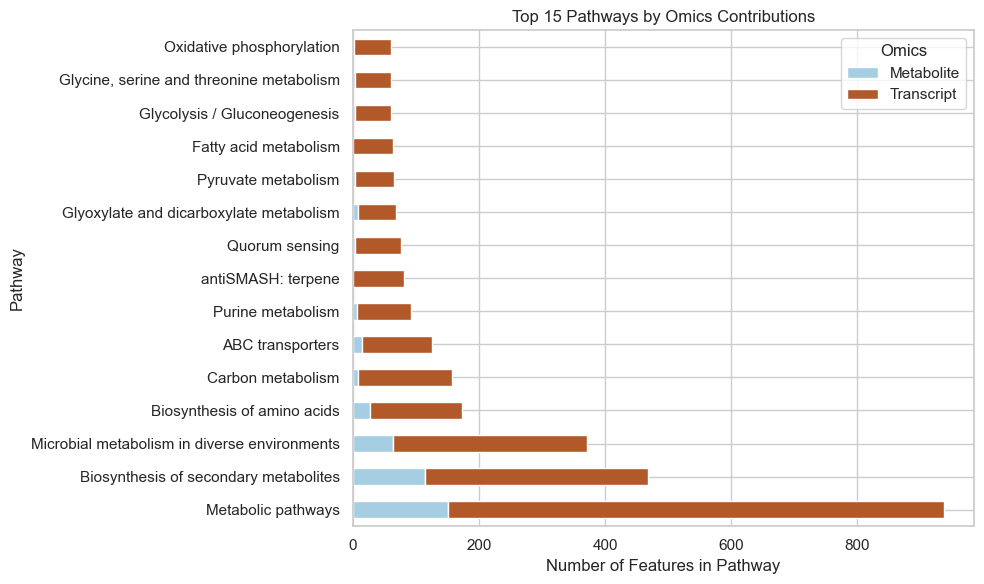

In [ ]:
# Confirmming the omics source
vip_annotated['Omics'] = vip_annotated['FeatureID'].apply(
    lambda f: 'Metabolite' if f in metab.columns else 'Transcript'
)

# Countting pathway hits per omics
pathway_omics = vip_annotated.groupby(['Pathway_name', 'Omics'])['FeatureID'].nunique().unstack(fill_value=0)

# Top pathways by total hits and plotting
pathway_omics['Total'] = pathway_omics.sum(axis=1)
top_contrib = pathway_omics.sort_values('Total', ascending=False).head(15).drop(columns='Total')

# Plottting the omics contributions
top_contrib.plot(kind='barh', stacked=True, figsize=(10, 6), colormap='Paired')
plt.xlabel("Number of Features in Pathway")
plt.ylabel("Pathway")
plt.title("Top 15 Pathways by Omics Contributions")
plt.tight_layout()
plt.show()


In [ ]:
# Saveing for reproducibility
vip_scores.to_csv("vip_scores.csv")
vip_annotated.to_csv("vip_annotated_features.csv", index=False)
vip_summary.to_csv("vip_pathway_summary.csv", index=False)
enrich_df.to_csv("pathway_enrichment_results.csv", index=False)
viz_df.to_csv("viz_data_vip_vs_enrichment.csv", index=False)


C:\Users\samri\AppData\Local\Temp\ipykernel_13820\3879968195.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=vip_annotated, x='Omics', y='VIP', palette='Pastel1')


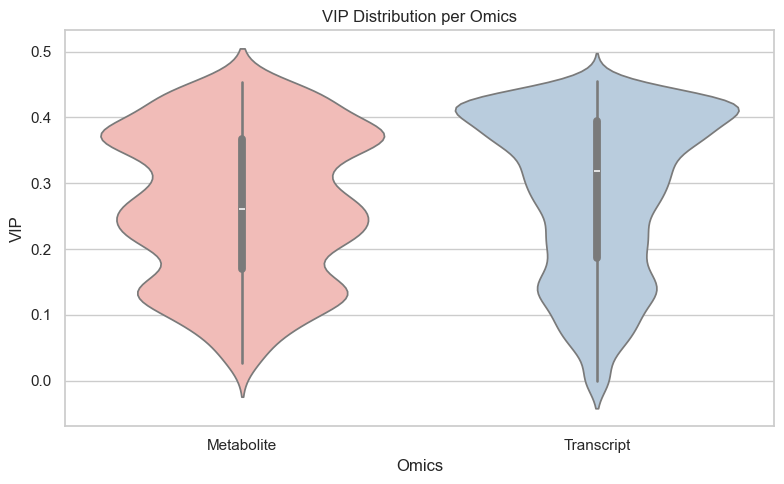

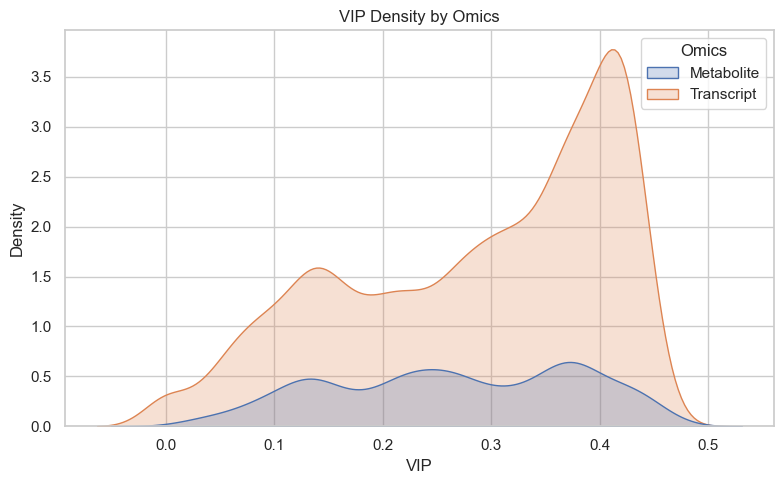

C:\Users\samri\AppData\Local\Temp\ipykernel_13820\3879968195.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=vip_annotated, x='Omics', y='VIP', palette='Pastel2')


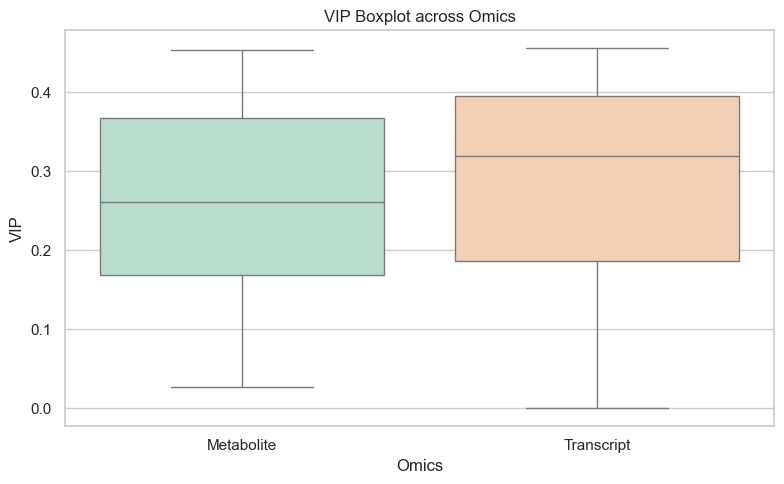

In [ ]:
# Additional Visualisations of VIP Distributions
# Violin plot of VIP distributions by omics
plt.figure(figsize=(8, 5))
sns.violinplot(data=vip_annotated, x='Omics', y='VIP', palette='Pastel1')
plt.title('VIP Distribution per Omics')
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 5))
sns.kdeplot(data=vip_annotated, x='VIP', hue='Omics', fill=True)
plt.title('VIP Density by Omics')
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 5))
sns.boxplot(data=vip_annotated, x='Omics', y='VIP', palette='Pastel2')
plt.title('VIP Boxplot across Omics')
plt.tight_layout()
plt.show()


Plots top 15 pathways by mean VIP score.

C:\Users\samri\AppData\Local\Temp\ipykernel_13820\375260244.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_per_omics = top_per_omics.groupby('Omics').apply(lambda df: df.nlargest(5, 'VIP_scaled')).reset_index(drop=True)
C:\Users\samri\AppData\Local\Temp\ipykernel_13820\375260244.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(


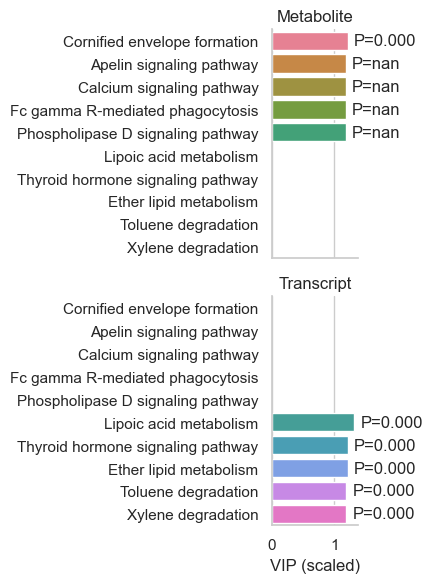

In [ ]:
# Preparingg  structure 
top_per_omics = vip_annotated.copy()
top_per_omics['VIP_scaled'] = (top_per_omics['VIP'] - vip_annotated['VIP'].mean()) / vip_annotated['VIP'].std()
top_per_omics = (top_per_omics.groupby(['Omics','Pathway_name'])
                                .agg(VIP_scaled=('VIP_scaled','mean'),
                                     P_val=('AdjPValue','min'))
                                .reset_index())
top_per_omics = top_per_omics.groupby('Omics').apply(lambda df: df.nlargest(5, 'VIP_scaled')).reset_index(drop=True)


# Plotting top pathways per omics with VIP and p-values
g = sns.catplot(
    data=top_per_omics,
    kind='bar',
    row='Omics',
    y='Pathway_name',
    x='VIP_scaled',
    palette='husl',
    height=3,
    aspect=1.5,
    dodge=False
)
g.set_titles("{row_name}")
for ax, (_, subdf) in zip(g.axes.flat, top_per_omics.groupby('Omics')):
    for i, row in subdf.iterrows():
        ax.text(row['VIP_scaled'] + 0.1, i, f"P={row['P_val']:.3f}", va='center')
g.set_axis_labels("VIP (scaled)", "")
plt.tight_layout()
plt.show()


In [ ]:
# Ranking by VIP score and enrichment significance
vip_ranked = vip_summary.sort_values("MeanVIP", ascending=False).copy()
enrich_ranked = enrich_df.sort_values("AdjP", ascending=True).copy()

# Merging to cross-check
final_pathways = vip_ranked.merge(enrich_ranked[['Pathway_id','AdjP']], on="Pathway_id", how="left")

# Optionally filterring to those that are significant
significant_pathways = final_pathways[final_pathways["AdjP"] < 0.05]


In [ ]:
# Top 10 Pathways by Combined Importance
top_final = significant_pathways.sort_values(["MeanVIP", "AdjP"], ascending=[False, True]).head(10)

print("Top 10 Pathways by Combined Importance:")
display(top_final[['Pathway_name', 'MeanVIP', 'AdjP', 'NumFeatures', 'MedianPValue']])

top_final.to_csv("top_pathways_vip_enrichment.csv", index=False)


Top 10 Pathways by Combined Importance:


,Pathway_name,MeanVIP,AdjP,NumFeatures,MedianPValue
16,Insect hormone biosynthesis,0.401127,0.011585,8,0.048294
28,Ascorbate and aldarate metabolism,0.361236,0.030487,11,0.005369
36,"antiSMASH: NRPS,T1PKS",0.348776,0.003886,19,0.004060
37,Citrate cycle (TCA cycle),0.345232,0.005039,42,0.007946
40,Starch and sucrose metabolism,0.337390,0.002690,35,0.031479
47,Pyruvate metabolism,0.331337,0.000139,66,0.008245
51,Glycolysis / Gluconeogenesis,0.329738,0.000282,61,0.025978
52,Other carbon fixation pathways,0.328062,0.005751,48,0.004202
64,Two-component system,0.323116,0.032983,57,0.059499
75,Terpenoid backbone biosynthesis,0.315016,0.033431,26,0.008175


Using MBPLS for combined pathway scores/analysis

In [22]:
from mbpls.mbpls import MBPLS
from sklearn.model_selection import StratifiedKFold


In [ ]:
# Combining metabolomics and transcriptomics PCA blocks (use PCA or KPCA output here)
mbpls = MBPLS(n_components=2)
mbpls.fit([metab_s, trans_s], y)

c:\Users\samri\Documents\101_bioinformatics\python\Visual_studio_code\.conda\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\samri\Documents\101_bioinformatics\python\Visual_studio_code\.conda\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\samri\Documents\101_bioinformatics\python\Visual_studio_code\.conda\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


MBPLS()

In [ ]:
# Extracting block scores
r2 = mbpls.r2_score([metab_s, trans_s], y)
print(f"R² Score (Y Explained): {r2:.3f}")


R² Score (Y Explained): 0.993


c:\Users\samri\Documents\101_bioinformatics\python\Visual_studio_code\.conda\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\samri\Documents\101_bioinformatics\python\Visual_studio_code\.conda\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Function to compute VIP scores for multi-block PLS.

In [ ]:
# Calculating VIP scores for multi-block PLS
def VIP_multiBlock(x_weights, x_superscores, x_loadings, y_loadings):
    weights = np.vstack(x_weights)
    sumsquares = np.sum(x_superscores**2, axis=0) * np.sum(y_loadings**2, axis=0)
    p = np.vstack(x_loadings).shape[0]
    vip_scores = np.sqrt(p * np.sum(sumsquares * (weights**2), axis=1) / np.sum(sumsquares))
    return vip_scores

vip_scores = VIP_multiBlock(mbpls.W_, mbpls.Ts_, mbpls.P_, mbpls.V_)


In [ ]:
# Visualising top VIPs from multi-block PLS
all_feats = list(metab_s.columns) + list(trans_s.columns)
vip_series = pd.Series(vip_scores, index=all_feats, name="MBPLS_VIP")

print("\nTop Pathways by VIP Score:")
print(vip_series.sort_values(ascending=False).head(15))



Top Pathways by VIP Score:
C05790       3.427142
NPA001555    3.427018
NPA002617    3.426258
NPA001689    3.425780
C05828       3.420980
C19035       3.411192
C06931       3.409667
C00122       3.408760
C09015       3.406473
NPA023370    3.398588
NPA009166    3.395134
NPA017221    3.393747
C15606       3.392793
C07375       3.383960
C02533       3.383027
Name: MBPLS_VIP, dtype: float64


In [ ]:
# Bootstrap Block Contributions
from scipy import stats

n_boot = 100
bips = []
explained_y = []

# Bootstrap to estimate block contributions and their variability
for _ in range(n_boot):
    idxs = metab_s.sample(frac=1.0, replace=True).index
    mbpls_b = MBPLS(n_components=2)
    mbpls_b.fit([metab_s.loc[idxs], trans_s.loc[idxs]], y[metab_s.index.get_indexer(idxs)])
    bips.append(mbpls_b.A_corrected_)
    explained_y.append(mbpls_b.explained_var_y_)

bips = np.array(bips)
print("Mean Block Contributions:\n", np.mean(bips, axis=0))
print("SEM of Contributions:\n", stats.sem(bips, axis=0))


c:\Users\samri\Documents\101_bioinformatics\python\Visual_studio_code\.conda\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\samri\Documents\101_bioinformatics\python\Visual_studio_code\.conda\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\samri\Documents\101_bioinformatics\python\Visual_studio_code\.conda\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\samri\Documents\101_bioinformatics\python\Visual_studio_code\.conda\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Mean Block Contributions:
 [[0.45239341 0.55912601]
 [0.54760659 0.44087399]]
SEM of Contributions:
 [[0.00153678 0.00352791]
 [0.00153678 0.00352791]]


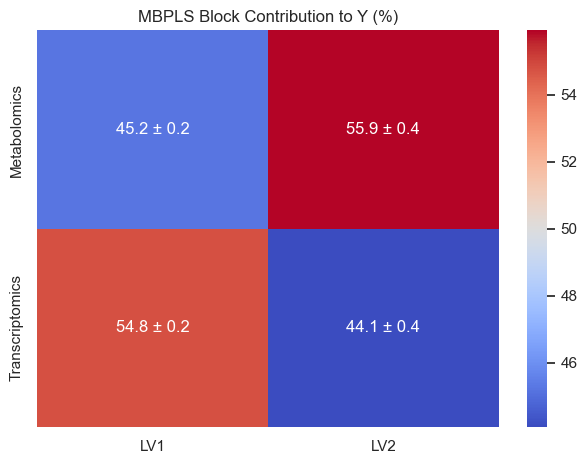

In [ ]:
# Visualising Block Contributions
import seaborn as sns
import matplotlib.pyplot as plt

# Preparing annotations with mean ± SEM
mean_bips = np.around(np.mean(bips, axis=0)*100, 1).astype(str)
sem_bips = np.around(stats.sem(bips, axis=0)*100, 1).astype(str)

lab = np.char.add(np.char.add(mean_bips, ' ± '), sem_bips)

# Heatmap of block contributions with annotations
sns.heatmap(np.mean(bips, axis=0)*100, cmap='coolwarm', annot=lab, fmt='', 
            yticklabels=['Metabolomics', 'Transcriptomics'], xticklabels=["LV1", "LV2"])
plt.title("MBPLS Block Contribution to Y (%)")
plt.tight_layout()
plt.show()


In [29]:
# Get superscores from MBPLS (LV1 and LV2 per sample)
superscores = pd.DataFrame(mbpls.Ts_, columns=["LV1", "LV2"], index=metab_s.index)
superscores["Group"] = y if isinstance(y, pd.Series) else pd.Series(y, index=metab_s.index)


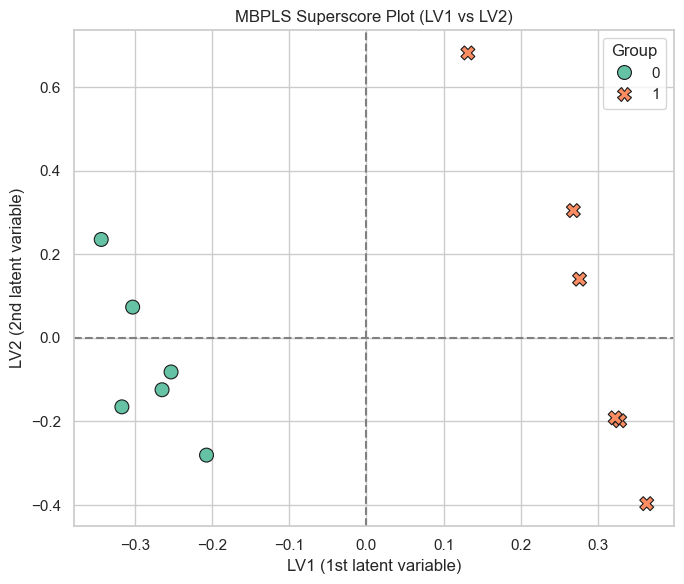

In [ ]:
# Visualising Superscores
import seaborn as sns
import matplotlib.pyplot as plt

# Scatter plot of superscores colored by group
plt.figure(figsize=(7, 6))
sns.scatterplot(data=superscores, x="LV1", y="LV2", hue="Group", style="Group", s=100, palette="Set2", edgecolor="k")
plt.axhline(0, linestyle='--', color='gray')
plt.axvline(0, linestyle='--', color='gray')
plt.title("MBPLS Superscore Plot (LV1 vs LV2)")
plt.xlabel("LV1 (1st latent variable)")
plt.ylabel("LV2 (2nd latent variable)")
plt.legend(title="Group")
plt.tight_layout()
plt.show()


In [ ]:
# Preparing pathway annotation structure for heatmap
mo_paths_all = pd.DataFrame({
    "Pathway_name": all_feats  # or some cleaned version if names are coded
}, index=all_feats)


C:\Users\samri\AppData\Local\Temp\ipykernel_13820\3946814079.py:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sort_values("VIP", ascending=False).head(10))


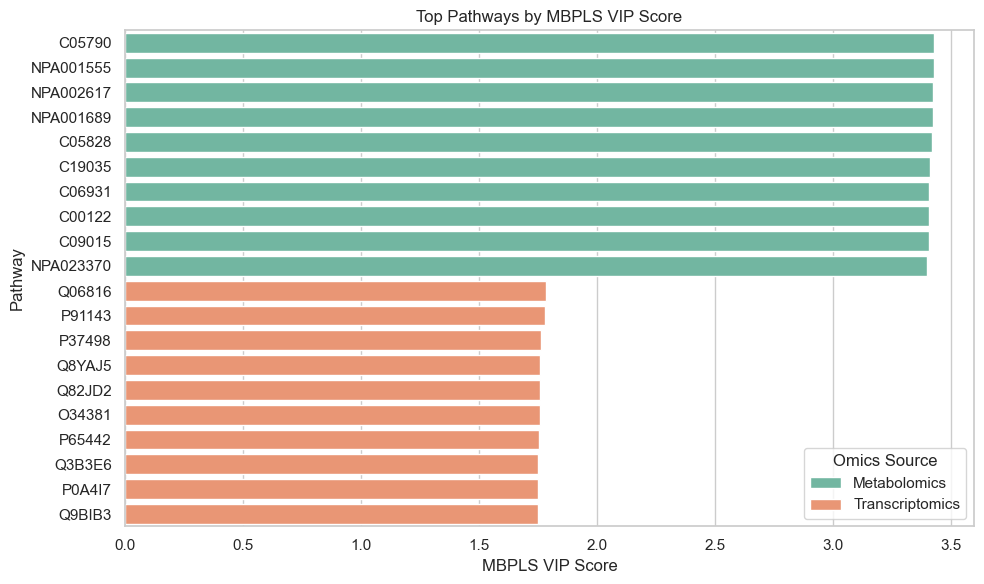

In [ ]:
# Combiningg MBPLS VIPs with feature metadata
vip_df = pd.DataFrame({
    "VIP": vip_series.values,
    "Feature": all_feats,
    "Source": ["Metabolomics"] * metab_s.shape[1] + ["Transcriptomics"] * trans_s.shape[1]
}).set_index("Feature")

# Useing the feature names directly as pathway names
vip_df["Name"] = vip_df.index

# Getting the top pathways per omics block
top_vips_by_source = (
    vip_df
    .groupby("Source")
    .apply(lambda g: g.sort_values("VIP", ascending=False).head(10))
    .reset_index(drop=True)
)

# Plottingg the top pathways by MBPLS VIP scores
plt.figure(figsize=(10, 6))
sns.barplot(
    data=top_vips_by_source,
    x="VIP",
    y="Name",
    hue="Source",
    dodge=False,
    palette="Set2"
)
plt.title("Top Pathways by MBPLS VIP Score")
plt.xlabel("MBPLS VIP Score")
plt.ylabel("Pathway")
plt.tight_layout()
plt.legend(title="Omics Source")
plt.show()


In [ ]:
# Normalising pathway names for merging
vip_df["Pathway"] = vip_df["Name"].str.lower().str.strip()  # normalize names


In [ ]:
# Scaling VIP scores within each omics source for better visual comparison
vip_df["VIP_scaled"] = vip_df.groupby("Source")["VIP"].transform(
    lambda x: (x - x.mean()) / x.std()
)


In [ ]:
# creating aggregated view of VIPs by pathway
agg_vips = (
    vip_df
    .groupby("Pathway")
    .agg({
        "VIP": "sum",
        "VIP_scaled": "sum",
        "Source": lambda x: ", ".join(sorted(set(x)))
    })
    .sort_values("VIP_scaled", ascending=False)
)


In [36]:
print(pathway_long.columns.tolist())


['Pathway_id', 'Pathway_name', 'Variable', 'FeatureID']


In [37]:
vip_df_reset = vip_df.reset_index()  # Contains 'Feature' column
vip_merged = vip_df_reset.merge(pathway_long, left_on="Feature", right_on="FeatureID", how="inner")



In [ ]:
# Z-score VIPs per omics source for comparability
vip_merged["VIP_scaled"] = vip_merged.groupby("Source")["VIP"].transform(
    lambda x: (x - x.mean()) / x.std()
)

# Groupingg by Pathway and sum across blocks
agg_pathways = (
    vip_merged
    .groupby(["Pathway_id", "Pathway_name"])
    .agg({
        "VIP": "sum",
        "VIP_scaled": "sum",
        "Source": lambda x: ", ".join(sorted(set(x)))
    })
    .sort_values("VIP_scaled", ascending=False)
)


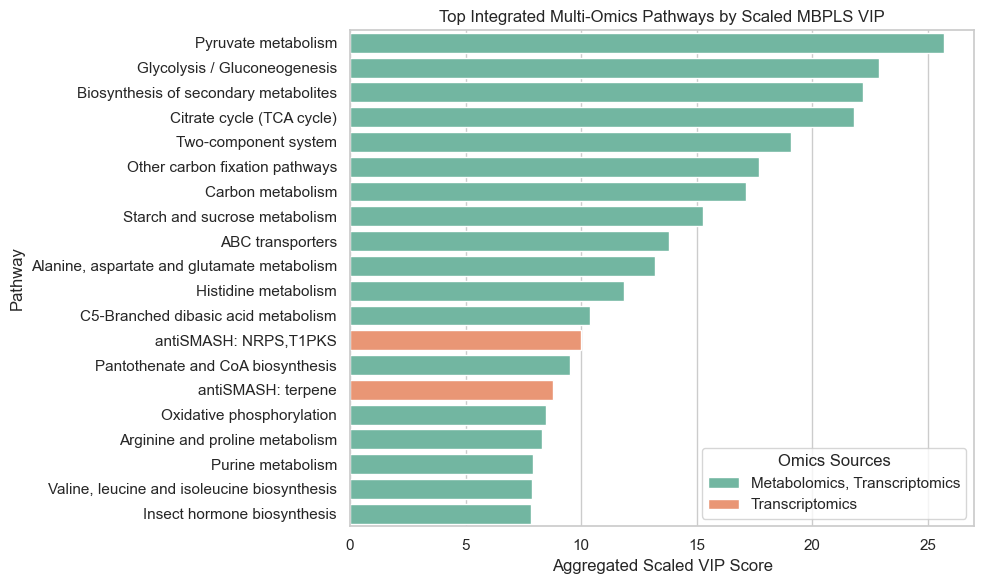

In [ ]:
# Plottingg the top integrated pathways by scaled VIP
plt.figure(figsize=(10, 6))
sns.barplot(
    data=agg_pathways.head(20).reset_index(),
    x="VIP_scaled",
    y="Pathway_name",
    hue="Source",
    dodge=False,
    palette="Set2"
)
plt.title("Top Integrated Multi-Omics Pathways by Scaled MBPLS VIP")
plt.xlabel("Aggregated Scaled VIP Score")
plt.ylabel("Pathway")
plt.tight_layout()
plt.legend(title="Omics Sources")
plt.show()


In [40]:
print(pval_db.columns.tolist())

['Omics', 'FeatureID', 'PValue', 'AdjPValue']


In [ ]:
# Merging adjusted p-values into the VIP annotated DataFrame
pval_db = pval_db.rename(columns={"FeatureID": "Feature"})

vip_merged_p = vip_merged.merge(pval_db[["Feature", "AdjPValue"]], left_on="Feature", right_on="Feature", how="left")



In [ ]:
# Aggregating minimum adjusted p-value per pathway
agg_pathways["Min_AdjP"] = (
    vip_merged_p.groupby(["Pathway_id", "Pathway_name"])["AdjPValue"].min()
)


In [ ]:
# Filteringg significant pathways
significant_pathways = agg_pathways[agg_pathways["Min_AdjP"] < 0.05]


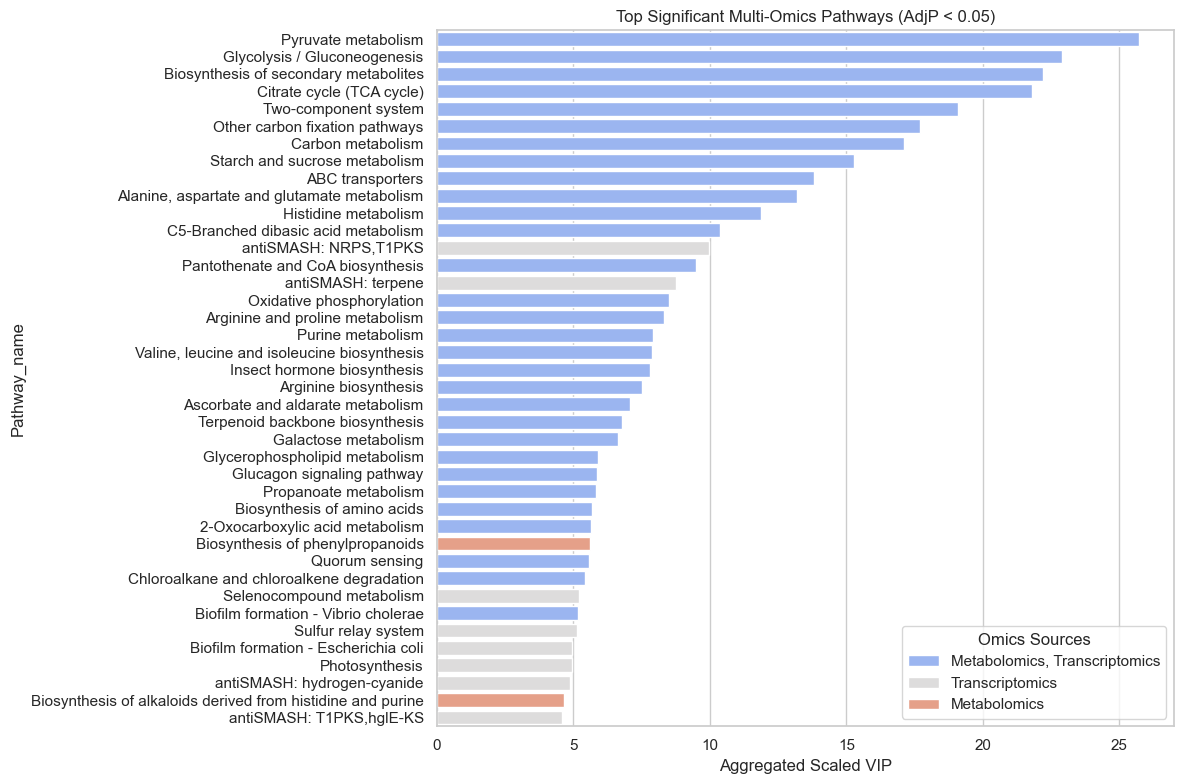

In [ ]:
# Plottingg the top significant pathways by scaled VIP
plt.figure(figsize=(12, 8))
sns.barplot(
    data=significant_pathways.sort_values("VIP_scaled", ascending=False).head(40).reset_index(),
    x="VIP_scaled",
    y="Pathway_name",
    hue="Source",
    dodge=False,
    palette="coolwarm"
)
plt.title("Top Significant Multi-Omics Pathways (AdjP < 0.05)")
plt.xlabel("Aggregated Scaled VIP")
plt.tight_layout()
plt.legend(title="Omics Sources")
plt.show()


In [ ]:
# Counting the number of features per pathway
feat_counts = (
    vip_merged_p
    .groupby(["Pathway_id", "Pathway_name"])
    .size()
    .rename("Num_Features")
)

# Assembling the final summary table
summary_table = agg_pathways.copy()

# Adding the min adjusted p-value
summary_table["Min_AdjP"] = (
    vip_merged_p.groupby(["Pathway_id", "Pathway_name"])["AdjPValue"]
    .min()
)

# Adding the number of features per pathway
summary_table = summary_table.join(feat_counts)

# Reordering and cleaning up
summary_table = summary_table.reset_index()[[
    "Pathway_name", "Pathway_id", "VIP", "VIP_scaled", "Min_AdjP", "Num_Features", "Source"
]]

# Sortting by importance
summary_table = summary_table.sort_values("VIP_scaled", ascending=False)


In [46]:
summary_table["Min_AdjP"] = summary_table["Min_AdjP"].apply(lambda x: f"{x:.2e}")
summary_table["VIP_scaled"] = summary_table["VIP_scaled"].round(2)
summary_table["VIP"] = summary_table["VIP"].round(2)


In [47]:
print(summary_table.head(20))


                                   Pathway_name Pathway_id     VIP  \
0                           Pyruvate metabolism   map00620   88.84   
1                  Glycolysis / Gluconeogenesis   map00010   81.52   
2         Biosynthesis of secondary metabolites   map01110  626.19   
3                     Citrate cycle (TCA cycle)   map00020   63.36   
4                          Two-component system   map02020   77.94   
5                Other carbon fixation pathways   map00720   67.12   
6                             Carbon metabolism   map01200  191.16   
7                 Starch and sucrose metabolism   map00500   47.12   
8                              ABC transporters   map02010  159.56   
9   Alanine, aspartate and glutamate metabolism   map00250   63.22   
10                         Histidine metabolism   map00340   47.74   
11          C5-Branched dibasic acid metabolism   map00660   26.37   
12                        antiSMASH: NRPS,T1PKS  BGC_r1c10   25.93   
13            Pantot

In [ ]:
# Computing the adjP summaries from vip_annotated with p-values
adjp_summary = (
    vip_merged_p
    .groupby(["Pathway_id", "Pathway_name"])["AdjPValue"]
    .agg(min_adjP="min", max_adjP="max", mean_adjP="mean")
    .reset_index()
)

# Merging into summary_table
summary_table = summary_table.merge(adjp_summary, on=["Pathway_id", "Pathway_name"], how="left")

# Format p-values in scientific notation
for col in ["min_adjP", "max_adjP", "mean_adjP"]:
    summary_table[col] = summary_table[col].apply(lambda x: f"{x:.2e}" if pd.notnull(x) else x)


In [ ]:
# Countting the features per omics type
omics_counts = (
    vip_merged_p.groupby(["Pathway_id", "Pathway_name", "Source"])["Feature"]
    .nunique()
    .unstack(fill_value=0)
    .reset_index()
    .rename(columns={
        "Transcriptomics": "n_transcriptomic",
        "Metabolomics": "n_metabolomic"
    })
)

# Merging into summary_table
summary_table = summary_table.merge(omics_counts, on=["Pathway_id", "Pathway_name"], how="left")

# Filling NaNs with 0
summary_table["n_features_total"] = (
    summary_table["n_transcriptomic"] + summary_table["n_metabolomic"]
)


In [ ]:
# Final reordering of columns
summary_table = summary_table[[
    "Pathway_id", "Pathway_name",
    "VIP", "VIP_scaled",
    "n_transcriptomic", "n_metabolomic", "n_features_total",
    "min_adjP", "max_adjP", "mean_adjP"
]]


In [ ]:
# Saving the final summary table
summary_table.to_csv("mvMoM_stats.csv", index=False)


This table is then exported to csv fpor use in the other notebook to create the final summary table.